In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import seaborn as sns

/Users/sawale/Documents/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes.parquet")

df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/joke_metrics_dataset_regression")
df.shape

(565, 6)

In [4]:
df.head()

,date,joke,score,humor,offensiveness,sentiment
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,0.42,61.98,-50.0
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,60.00,15.00,-30.0
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,0.45,1.00,30.0
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,87.50,12.00,-16.0
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,80.00,1.50,60.0


In [5]:
from sklearn.preprocessing import StandardScaler

# Define the numerical columns to scale
numerical_columns = ['humor', 'offensiveness', 'sentiment']

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to the numerical columns and transform them
# df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [6]:
df.head()

,date,joke,score,humor,offensiveness,sentiment
412005,2018-08-23 13:28:10,What does a racist joke and crossing the stree...,17810.0,0.42,61.98,-50.0
161935,2016-04-15 20:04:30,I have spent the past year looking for my ex's...,2.0,60.00,15.00,-30.0
138637,2015-12-19 15:24:52,Why is. Dr.Dre's Headphones so popular? Beats me.,1.0,0.45,1.00,30.0
446460,2018-12-17 23:55:09,I wish I could be like Jesus Christ... That so...,6.0,87.50,12.00,-16.0
486819,2019-04-15 11:12:03,Why did the seagull fly over the sea? Because ...,10.0,80.00,1.50,60.0


# EDA on joke length

Token indices sequence length is longer than the specified maximum sequence length for this model (1715 > 512). Running this sequence through the model will result in indexing errors


Five-Point Summary for Joke Token Counts:
min: 4
Q1: 17.0
median: 24.0
Q3: 43.0
max: 2385
Percentage of documents with token counts > 512: 0.53%
Token count at 99.9th percentile: 2007.1200000000238


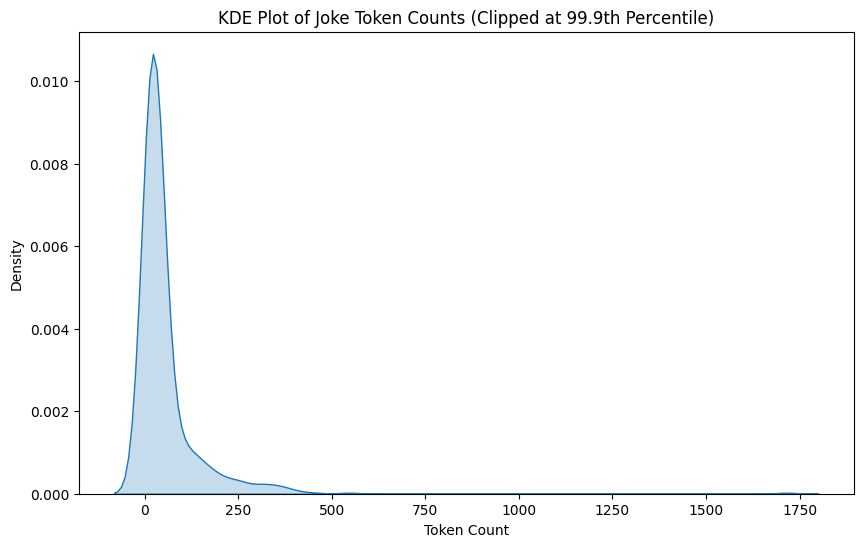

In [7]:
# Step 1: Initialize the tokenizer from Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

# Step 2: Create a new column to count the tokens in each joke.
# Here, tokenizer.tokenize(x) returns a list of tokens, and we take its length.
df['joke_token_count'] = df['joke'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 3: Compute the five-number summary for token counts.
five_point_summary = {
    'min': df['joke_token_count'].min(),
    'Q1': df['joke_token_count'].quantile(0.25),
    'median': df['joke_token_count'].median(),
    'Q3': df['joke_token_count'].quantile(0.75),
    'max': df['joke_token_count'].max()
}

print("Five-Point Summary for Joke Token Counts:")
for key, value in five_point_summary.items():
    print(f"{key}: {value}")

# Step 4: Calculate the percentage of documents with token count greater than 512.
docs_over_512 = (df['joke_token_count'] > 512).sum()
total_docs = len(df)
percentage_over_512 = (docs_over_512 / total_docs) * 100
print(f"Percentage of documents with token counts > 512: {percentage_over_512:.2f}%")

# Step 5: Determine the clip value: the 99.9th percentile of the token counts.
clip_value = df['joke_token_count'].quantile(0.999)
print(f"Token count at 99.9th percentile: {clip_value}")

# Step 6: Plot the KDE (Kernel Density Estimate) of the token count distribution.
# We filter the data to include only those documents with token counts less than or equal to clip_value.
plt.figure(figsize=(10, 6))
filtered_data = df[df['joke_token_count'] <= clip_value]
sns.kdeplot(data=filtered_data, x='joke_token_count', fill=True)
plt.title("KDE Plot of Joke Token Counts (Clipped at 99.9th Percentile)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.show()

# Analysis on target columns

5-Point Summary (Min, 25th, Median, 75th, Max):
     humor  offensiveness  sentiment
min  -1.00          -1.00     -91.22
25%   0.85           1.50     -10.00
50%  70.00          12.39      30.00
75%  81.20          15.20      70.00
max  98.10         100.00      97.00

Standard Deviation:
humor            36.451856
offensiveness    11.236912
sentiment        44.349230
dtype: float64


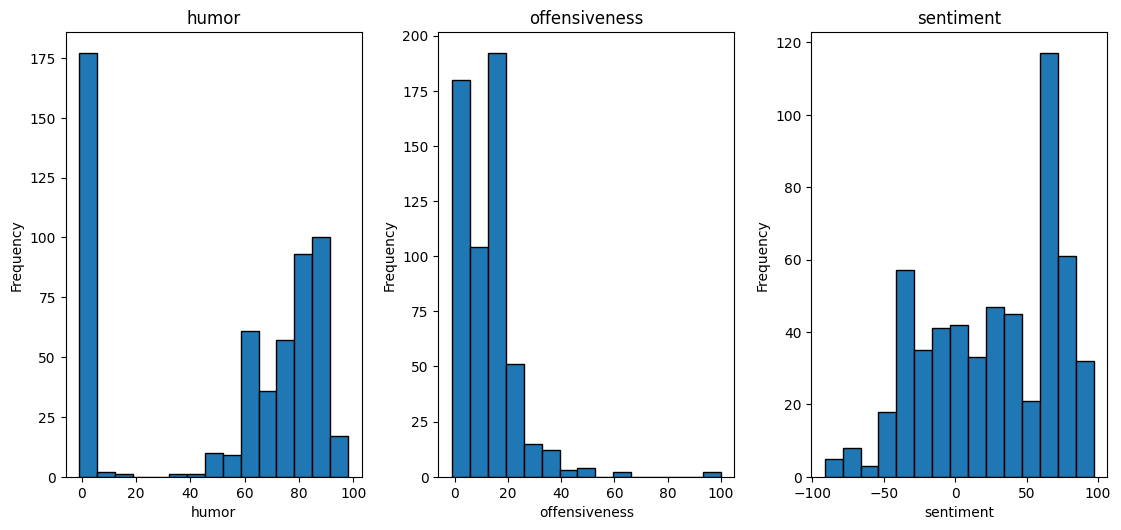

In [8]:
# Assuming you already have the DataFrame loaded as 'df'
# List of numerical columns to analyze
numeric_cols = [
    'humor', 
    'offensiveness', 
    'sentiment'
]

# 1. Calculate the 5-point summary for each numerical column.
# Using the describe() function with percentiles provides a good summary.
summary_stats = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75])
five_point_summary = summary_stats.loc[['min', '25%', '50%', '75%', 'max']]
print("5-Point Summary (Min, 25th, Median, 75th, Max):")
print(five_point_summary)

# 2. Extracting the Standard Deviation for each column.
std_devs = df[numeric_cols].std()
print("\nStandard Deviation:")
print(std_devs)

# 3. Plot the distribution for each numerical column
# Create a separate histogram for each column.
num_columns = len(numeric_cols)
plt.figure(figsize=(15, 10))
for idx, column in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, idx)  # Arrange subplots in a 2-row, 4-column grid.
    plt.hist(df[column].dropna(), bins=15, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Chroma Analysis

Yearly Average Metrics:
          humor  offensiveness  sentiment
year                                     
2011  62.662500       6.580000  34.517500
2012  60.825000      11.692500   7.100000
2013  66.532000      11.918667  11.846667
2014  51.244737      12.553947  22.078158
2015  49.321370      11.381096  28.500685
2016  52.177604      13.880521  17.890104
2017  50.159072      12.438557  28.328041
2018  52.120566      12.177642  26.758113
2019  53.413145      11.644194  35.492984


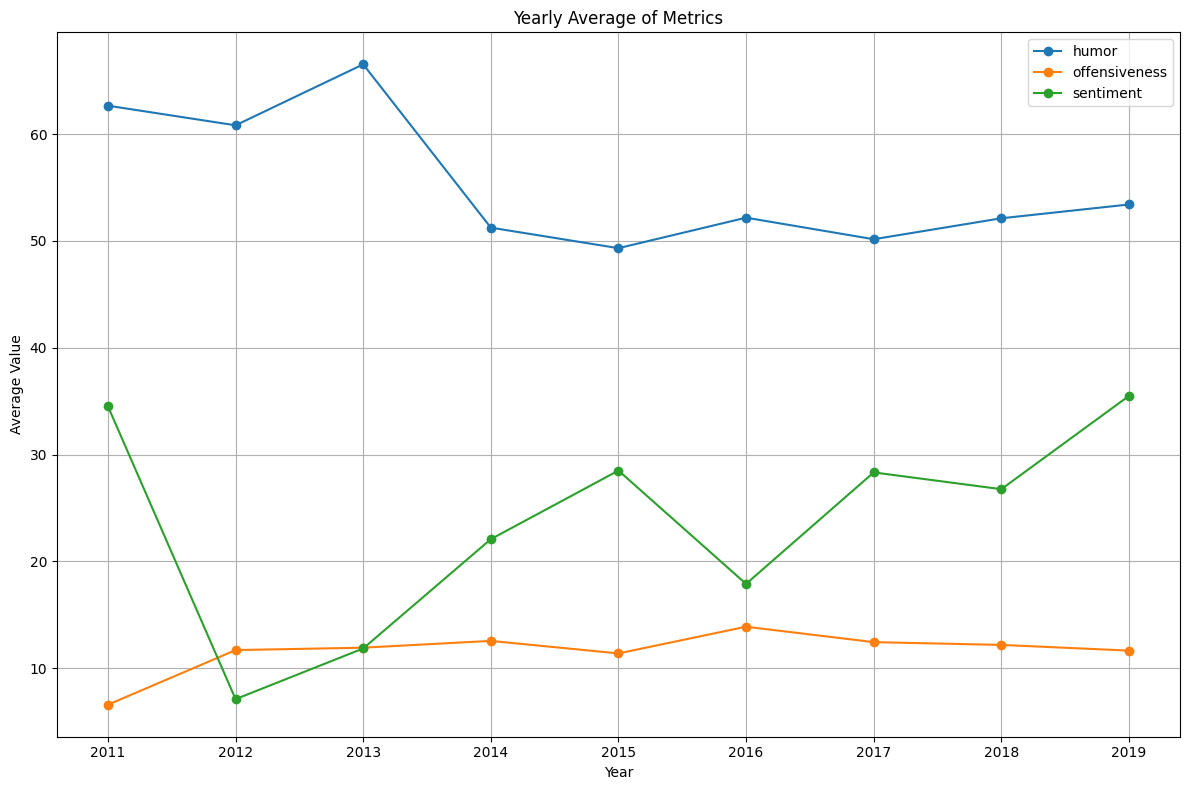

In [9]:
# Ensure that the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year

# Define the numerical columns to analyze
numeric_cols = [
    'humor', 
    'offensiveness', 
    'sentiment'
]

# Group by year and calculate the mean for each metric
yearly_averages = df.groupby('year')[numeric_cols].mean()

# Print the yearly averages DataFrame
print("Yearly Average Metrics:")
print(yearly_averages)

# Plot each metric's yearly average on a single plot for comparison
plt.figure(figsize=(12, 8))
for metric in numeric_cols:
    plt.plot(yearly_averages.index, yearly_averages[metric], marker='o', linestyle='-', label=metric)

plt.title('Yearly Average of Metrics')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

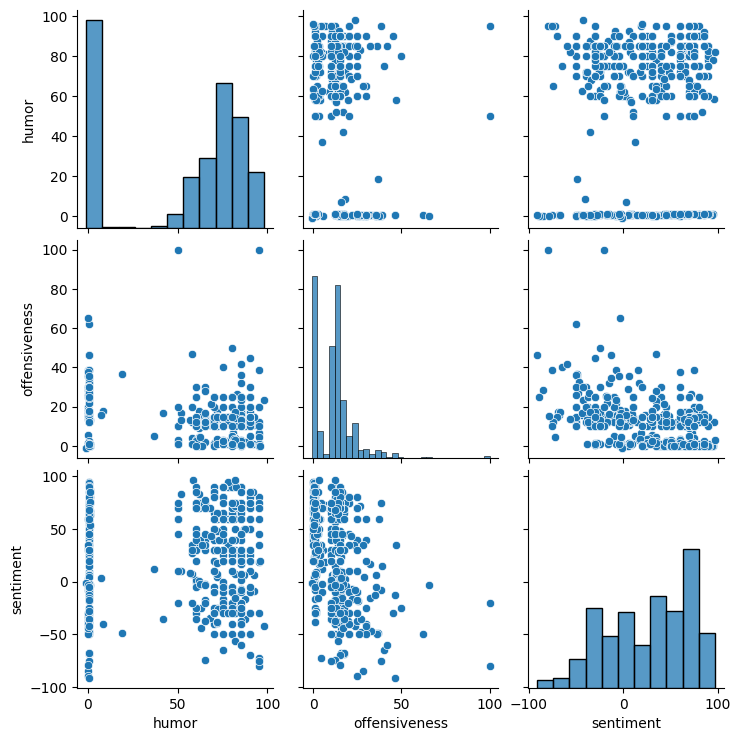

In [13]:
sns.pairplot(df[["humor","offensiveness", "sentiment"]])
plt.show()